# Figure 12: NH Sea Ice Extent (SIE) Skill 
- SIE == total area of grid cells where ice fraction exceeds 0.15

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import copy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xesmf as xe
%matplotlib inline

# import plotting and other utilities from SMYLEutils
from SMYLEutils import calendar_utils as cal
from SMYLEutils import mapplot_utils as maps
from SMYLEutils import colorbar_utils as cbars
from SMYLEutils import regrid_utils as regrid

# import ESP-Lab modules
from esp_lab import data_access
from esp_lab import stats

In [2]:
import dask
from dask.distributed import wait
dask.__version__

'2021.09.0'

## Preprocessing:  Data I/O using Dask

### Create Dask Cluster

In [68]:
# Close out Dask Cluster and release workers:
# NOTE:  only run this cell to terminate Dask Cluster!
cluster.close()
client.close()

distributed.core - ERROR - Exception while handling op register-client
Traceback (most recent call last):
  File "/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/distributed/core.py", line 502, in handle_comm
    result = await result
  File "/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/distributed/scheduler.py", line 5249, in add_client
    self.remove_client(client=client)
  File "/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/distributed/scheduler.py", line 5276, in remove_client
    self.client_releases_keys(
  File "/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/distributed/scheduler.py", line 5014, in client_releases_keys
    self.transitions(recommendations)
  File "/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/distributed/scheduler.py", line 7119, in transitions
    self.send_all(client_msgs, worker_msgs)
  File "/glade/wor

In [3]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='20GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=20GB',
        project='NCGD0011',
        walltime='02:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status',
        'array.slicing.split_large_chunks': True
    })
    client = Client(cluster)
    return cluster, client

In [4]:
cluster, client = get_ClusterClient()
cluster.scale(30) #adapt(minimum_jobs=0, maximum_jobs=24)

/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42381 instead
  warnings.warn(


In [5]:
cluster

### Read in CICE monthly data; Convert to Seasonal averages (DJF, MAM, JJA, SON)
- Chosen field is returned as a dask array with leading dimensions of Y (initialization year), M (ensemble member), and L (lead season). For example, for November starts, L=1 corresponds to first DJF season.
- "time" which gives prediction verification time (centered time for a given season) is also dimensioned with (Y,L)

In [19]:
def preprocessor(d0,nlead,field):
    """ This preprocessor is applied on an individual timeseries file basis. Edit this appropriately
    for your analysis to speed up processing. 
    
    Here,
        - reset monthly time to mid-month value
        - select top vertical level and only nlead time values
        - drop fields unrelated to SST
    """
    d0 = cal.time_set_midmonth(d0,'time')
    d0 = d0.isel(time=slice(0, nlead))
    d0 = d0.assign_coords(L=("time", np.arange(d0.sizes["time"])+1))
    d0 = d0.swap_dims({"time": "L"})
    d0 = d0.reset_coords(["time"])
    d0["time"] = d0.time.expand_dims("Y")
    d0 = d0[[field,'time','TLAT','TLON','tarea']].drop(['ULAT','ULON'])
    d0 = d0.chunk({'L':-1})
    return d0

In [20]:
%time
# SMYLE-NOV AICE data
# process all 20 ensemble members, all start dates from 1970-2019:
field = 'aice'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.cice.h.'
filetemplate = datadir+casename+'/ice/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
inityears = np.arange(1970,2020,1)
startmonth = 11
chunk = {}
smyle11 = data_access.get_monthly_data(filetemplate,filetype,ens,nlead,field,inityears,startmonth,preprocessor,chunks=chunk)
smyle11.nbytes/1e9 #GB

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


11.797964912

In [21]:
%%time
smyle11_seas = cal.mon_to_seas_dask2(smyle11).persist()
daskout = wait(smyle11_seas)

CPU times: user 34 s, sys: 719 ms, total: 34.7 s
Wall time: 36.7 s


In [22]:
# SMYLE-FEB aice data
startmonth = 2
smyle02 = data_access.get_monthly_data(filetemplate,filetype,ens,nlead,field,inityears,startmonth,preprocessor,chunks=chunk)
smyle02.nbytes/1e9 #GB

11.797964912

In [23]:
%%time
smyle02_seas = cal.mon_to_seas_dask2(smyle02).persist()
daskout = wait(smyle02_seas)

CPU times: user 37 s, sys: 870 ms, total: 37.9 s
Wall time: 41.2 s


In [24]:
# SMYLE-MAY aice data
startmonth = 5
smyle05 = data_access.get_monthly_data(filetemplate,filetype,ens,nlead,field,inityears,startmonth,preprocessor,chunks=chunk)
smyle05.nbytes/1e9 #GB

11.797964912

In [25]:
%%time
smyle05_seas = cal.mon_to_seas_dask2(smyle05).persist()
daskout = wait(smyle05_seas)

CPU times: user 41.6 s, sys: 980 ms, total: 42.6 s
Wall time: 49.1 s


In [26]:
# SMYLE-AUG aice data
startmonth = 8
smyle08 = data_access.get_monthly_data(filetemplate,filetype,ens,nlead,field,inityears,startmonth,preprocessor,chunks=chunk)
smyle08.nbytes/1e9 #GB

11.797964912

In [27]:
%%time
smyle08_seas = cal.mon_to_seas_dask2(smyle08).persist()
daskout = wait(smyle08_seas)

CPU times: user 36 s, sys: 794 ms, total: 36.7 s
Wall time: 39.7 s


### Get CESM2-LE members

In [28]:
import intake

catalog_file = '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'
col = intake.open_esm_datastore(catalog_file)
cesm2data = col.search(component='ice', 
                       variable=['aice'], 
                       frequency='month_1', 
                       experiment=['historical','ssp370'], 
                       forcing_variant='smbb')

/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/intake_esm/utils.py:96: DtypeWarning: Columns (5,6,9) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(catalog_path, **csv_kwargs), catalog_path


In [29]:
## The following is needed as a workaround for this issue with intake-esm:
## https://github.com/intake/intake-esm/issues/343
cesm2data.df = cesm2data.df.sort_values(by=['time_range'])

# Test that it gets timestamps in order:
#cesm2data.df[cesm2data.df.experiment == 'historical']

In [30]:
%%time
## Use preprocessor to return mid-month time
def preproc(ds):
    ds = cal.time_set_midmonth(ds,'time')
    return ds

dask.config.set(**{'array.slicing.split_large_chunks': True})
dsets = cesm2data.to_dataset_dict(preprocess=preproc)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


CPU times: user 17.2 s, sys: 608 ms, total: 17.9 s
Wall time: 20.8 s


In [31]:
dsets.keys()

dict_keys(['ice.ssp370.cice.h.smbb.aice', 'ice.historical.cice.h.smbb.aice'])

In [32]:
# Compute CESM2-LE aice mean over 50 members:
cesm2_hist = dsets['ice.historical.cice.h.smbb.aice'].aice
cesm2_ssp = dsets['ice.ssp370.cice.h.smbb.aice'].aice
cesm2_ifrac = xr.concat([cesm2_hist,cesm2_ssp],dim='time').mean('member_id').persist()

In [33]:
cesm2_ifrac

<xarray.DataArray 'aice' (time: 3012, nj: 384, ni: 320)>
dask.array<mean_agg-aggregate, shape=(3012, 384, 320), dtype=float32, chunksize=(120, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    TLON     (nj, ni) float32 320.6 321.7 322.8 323.9 325.1 ... nan nan nan nan
    TLAT     (nj, ni) float32 -79.22 -79.22 -79.22 -79.22 ... nan nan nan nan
    ULON     (nj, ni) float32 321.1 322.2 323.4 324.5 325.6 ... nan nan nan nan
    ULAT     (nj, ni) float32 -78.95 -78.95 -78.95 -78.95 ... nan nan nan nan
  * time     (time) object 1850-01-15 00:00:00 ... 2100-12-15 00:00:00
Dimensions without coordinates: nj, ni

### Compute SMYLE NH Sea Ice Extent

In [34]:
# Define latitude bounds for computing SIE
lat1 = 40.
lat2 = 90.

In [35]:
def POP_regional_areawgt(ds,lon_lim,lat_lim):
    tarea = (ds.tarea/(1000.**2)).load()
    tarea['units'] = 'km^2'
    tlat = ds.TLAT
    tlon = xr.where(ds.TLON>180.,ds.TLON-360.,ds.TLON)
    region = (tlat>=lat_lim[0]) & (tlat<=lat_lim[1]) & (tlon>=lon_lim[0]) & (tlon<=lon_lim[1])
    return xr.where(region,tarea.fillna(0),0)

def compute_SIE(ifrac,area):
    tmp = xr.where(ifrac>0.15,1,0)
    sie = (tmp*area).sum(("ni", "nj"))
    return sie

In [36]:
POPg16_arctic_area = POP_regional_areawgt(smyle11_seas,[-180.,180.],[lat1,lat2])

- Here, perform actual computation, returning xarray

In [37]:
%%time
smyle11_sie = compute_SIE(smyle11_seas.aice,POPg16_arctic_area).load()
smyle11_time = smyle11_seas.time.load()
smyle02_sie = compute_SIE(smyle02_seas.aice,POPg16_arctic_area).load()
smyle02_time = smyle02_seas.time.load()
smyle05_sie = compute_SIE(smyle05_seas.aice,POPg16_arctic_area).load()
smyle05_time = smyle05_seas.time.load()
smyle08_sie = compute_SIE(smyle08_seas.aice,POPg16_arctic_area).load()
smyle08_time = smyle08_seas.time.load()

CPU times: user 1min 18s, sys: 1.02 s, total: 1min 19s
Wall time: 1min 24s


In [38]:
# Convert to units of 1.e6 km^2
smyle11_sie = smyle11_sie/1.e6
smyle02_sie = smyle02_sie/1.e6
smyle05_sie = smyle05_sie/1.e6
smyle08_sie = smyle08_sie/1.e6

### Store datasets to disk for quicker processing next time 

In [136]:
%%time
## Save Fig data to file:
outdir = '/glade/scratch/yeager/SMYLE_paper/'
tmp = smyle11_sie.rename('SIE').to_dataset()
tmp['time'] = smyle11_time
tmp.to_netcdf(outdir+'SMYLE11_SIE_seas.nc')
tmp = smyle02_sie.rename('SIE').to_dataset()
tmp['time'] = smyle02_time
tmp.to_netcdf(outdir+'SMYLE02_SIE_seas.nc')
tmp = smyle05_sie.rename('SIE').to_dataset()
tmp['time'] = smyle05_time
tmp.to_netcdf(outdir+'SMYLE05_SIE_seas.nc')
tmp = smyle08_sie.rename('SIE').to_dataset()
tmp['time'] = smyle08_time
tmp.to_netcdf(outdir+'SMYLE08_SIE_seas.nc')

CPU times: user 137 ms, sys: 12.9 ms, total: 150 ms
Wall time: 303 ms


In [15]:
## Retrieve pre-saved Fig data:
outdir = '/glade/scratch/yeager/SMYLE_paper/'
smyle11_seas = xr.open_dataset(outdir+'SMYLE11_SIE_seas.nc')
smyle11_sie = smyle11_seas['SIE']
smyle11_time = smyle11_seas['time']
smyle02_seas = xr.open_dataset(outdir+'SMYLE02_SIE_seas.nc')
smyle02_sie = smyle02_seas['SIE']
smyle02_time = smyle02_seas['time']
smyle05_seas = xr.open_dataset(outdir+'SMYLE05_SIE_seas.nc')
smyle05_sie = smyle05_seas['SIE']
smyle05_time = smyle05_seas['time']
smyle08_seas = xr.open_dataset(outdir+'SMYLE08_SIE_seas.nc')
smyle08_sie = smyle08_seas['SIE']
smyle08_time = smyle08_seas['time']

### Compute CESM2-LE NH Sea Ice Extent

In [39]:
cesm2_sie= compute_SIE(cesm2_ifrac,POPg16_arctic_area).load()

In [40]:
cesm2_sie_seas = cesm2_sie.rolling(time=3,min_periods=3, center=True).mean().dropna('time',how='all')

In [41]:
cesm2_sie_seas =cesm2_sie_seas/1.e6

### Compute SMYLE-FOSI NH Sea Ice Extent

In [42]:
ds_fosi = xr.open_dataset('/glade/campaign/cesm/development/espwg/SMYLE/initial_conditions/SMYLE-FOSI/ice/proc/tseries/month_1/g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.SMYLE.005.cice.h.aice.030601-036812.nc')
fosi_montime = [cftime.DatetimeNoLeap(1958+year, 1+month, 15) for year in range(63) for month in range(12)]
ds_fosi['time'] = fosi_montime
fosi_sie = compute_SIE(ds_fosi.aice,POPg16_arctic_area)

In [43]:
fosi_sie.time

<xarray.DataArray 'time' (time: 756)>
array([cftime.DatetimeNoLeap(1958, 1, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1958, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1958, 3, 15, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2020, 10, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2020, 11, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2020, 12, 15, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1958-01-15 00:00:00 ... 2020-12-15 00:00:00
    units    <U4 'km^2'

In [44]:
fosi_sie_seas = fosi_sie.rolling(time=3,min_periods=3, center=True).mean().dropna('time',how='all')

In [45]:
fosi_sie_seas = fosi_sie_seas/1.e6

### Read in Pre-computed NSIDC NH Sea Ice Extent

In [46]:
import pandas

In [47]:
datadir = '/glade/p/cgd/oce/people/yeager/obs/seaice/NSIDC/SeaIceIndex/'
xrlist = []
for i in range(12):
    tmp = pandas.read_csv(datadir+'N_{}_extent_v3.0.csv'.format(str(i+1).zfill(2)),skipinitialspace=True).to_xarray()
    time = [cftime.DatetimeNoLeap(tmp.year[i],tmp.mo[i],15) for i in range(tmp.sizes['index'])]
    tmp = tmp.assign_coords(time=("index", time))
    tmp = tmp.swap_dims({"index": "time"}).drop(['index','mo','year','data-type','region'])
    xrlist.append(tmp)
obs_sie = xr.merge(xrlist).extent
obs_sie = obs_sie.where(obs_sie>-1)

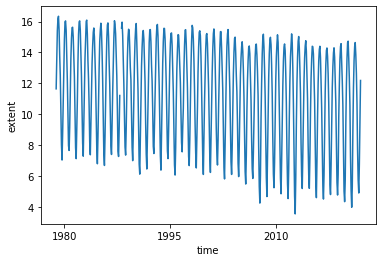

In [48]:
obs_sie.plot()

In [49]:
obs_sie_seas = obs_sie.rolling(time=3,min_periods=3, center=True).mean().dropna('time',how='all')

# Skill Analysis

In [50]:
# Use bespoke skill score functions for this analysis
import xskillscore as xs

def detrend_linear(dat, dim):
    """ linear detrend dat along the axis dim """
    params = dat.polyfit(dim=dim, deg=1)
    fit = xr.polyval(dat[dim], params.polyfit_coefficients)
    dat = dat-fit
    return dat

def leadtime_skill_byseas_withextra(mod_da,mod_time,obs_da,extra_da,cy0,cy1,detrend=False):
    ens = mod_da.mean('M')
    seasons = {2:'JFM',5:'AMJ',8:'JAS',11:'OND'}
    r_list = []
    p_list = []
    e_list = []
    r2_list = []
    p2_list = []
    e2_list = []
    for i in ens.L.values:
        ens_ts = ens.sel(L=i).rename({'Y':'time'})
        ens_time_year = mod_time.sel(L=i).dt.year.data
        ens_time_month = mod_time.sel(L=i).dt.month.data[0]
        obs_time_month = obs_da.time.dt.month
        obs_time_year = obs_da.time.dt.year
        extra_time_month = extra_da.time.dt.month
        extra_time_year = extra_da.time.dt.year
        obs_ts = obs_da.where(obs_time_month==ens_time_month).dropna('time')
        obs_ts = obs_ts.assign_coords(time=("time",obs_ts.time.dt.year.data))
        obs_ts = obs_ts.assign_coords({"season":seasons[ens_time_month]})
        obs_ts = obs_ts - obs_ts.sel(time=slice(cy0,cy1)).mean('time')
        extra_ts = extra_da.where(extra_time_month==ens_time_month).dropna('time')
        extra_ts = extra_ts.assign_coords(time=("time",extra_ts.time.dt.year.data))
        extra_ts = extra_ts.assign_coords({"season":seasons[ens_time_month]})
        extra_ts = extra_ts - extra_ts.sel(time=slice(cy0,cy1)).mean('time')
        ens_ts = ens_ts.assign_coords(time=("time",ens_time_year))
        a,b,c = xr.align(ens_ts,obs_ts,extra_ts)
        if detrend:
                a = detrend_linear(a,'time')
                b = detrend_linear(b,'time')
                c = detrend_linear(c,'time')
        r = xs.pearson_r(a,b,dim='time')
        e = xs.rmse(a,b,dim='time')/b.std('time')
        p = xs.pearson_r_eff_p_value(a,b,dim='time')
        r2 = xs.pearson_r(c,b,dim='time')
        e2 = xs.rmse(c,b,dim='time')/b.std('time')
        p2 = xs.pearson_r_eff_p_value(c,b,dim='time')
        r_list.append(r)
        e_list.append(e)
        p_list.append(p)
        r2_list.append(r2)
        e2_list.append(e2)
        p2_list.append(p2)
    corr = xr.concat(r_list,ens.L)
    pval = xr.concat(p_list,ens.L)
    rmse = xr.concat(e_list,ens.L)
    corr2 = xr.concat(r2_list,ens.L)
    pval2 = xr.concat(p2_list,ens.L)
    rmse2 = xr.concat(e2_list,ens.L)
    return xr.Dataset({'corr':corr,'pval':pval,'rmse':rmse,'corr2':corr2,'pval2':pval2,'rmse2':rmse2})

#### De-drift SMYLE data:

In [51]:
%%time
# Remove leadtime-dependent drift, using the following years for climatology:
climy0 = 1980
climy1 = 2015
smyle11_sie_dd,smyle11_sie_drift = stats.remove_drift(smyle11_sie,smyle11_time,climy0,climy1)
smyle02_sie_dd,smyle02_sie_drift = stats.remove_drift(smyle02_sie,smyle02_time,climy0,climy1)
smyle05_sie_dd,smyle05_sie_drift = stats.remove_drift(smyle05_sie,smyle05_time,climy0,climy1)
smyle08_sie_dd,smyle08_sie_drift = stats.remove_drift(smyle08_sie,smyle08_time,climy0,climy1)

CPU times: user 10.8 ms, sys: 11 µs, total: 10.8 ms
Wall time: 10.8 ms


In [52]:
cesm2_sie_seas = cesm2_sie_seas.sel(time=slice("1950","2021"))

In [53]:
%%time
# Correlation as a function of forecast lead month:
smyle11_skill_wfosi = leadtime_skill_byseas_withextra(smyle11_sie_dd,smyle11_time,obs_sie_seas,fosi_sie_seas,climy0,climy1,detrend=False).isel(L=slice(1,None))
smyle02_skill_wfosi = leadtime_skill_byseas_withextra(smyle02_sie_dd,smyle02_time,obs_sie_seas,fosi_sie_seas,climy0,climy1,detrend=False).isel(L=slice(1,None))
smyle05_skill_wfosi = leadtime_skill_byseas_withextra(smyle05_sie_dd,smyle05_time,obs_sie_seas,fosi_sie_seas,climy0,climy1,detrend=False).isel(L=slice(1,None))
smyle08_skill_wfosi = leadtime_skill_byseas_withextra(smyle08_sie_dd,smyle08_time,obs_sie_seas,fosi_sie_seas,climy0,climy1,detrend=False).isel(L=slice(1,None))

smyle11_skill_wfosi_dt = leadtime_skill_byseas_withextra(smyle11_sie_dd,smyle11_time,obs_sie_seas,fosi_sie_seas,climy0,climy1,detrend=True).isel(L=slice(1,None))
smyle02_skill_wfosi_dt = leadtime_skill_byseas_withextra(smyle02_sie_dd,smyle02_time,obs_sie_seas,fosi_sie_seas,climy0,climy1,detrend=True).isel(L=slice(1,None))
smyle05_skill_wfosi_dt = leadtime_skill_byseas_withextra(smyle05_sie_dd,smyle05_time,obs_sie_seas,fosi_sie_seas,climy0,climy1,detrend=True).isel(L=slice(1,None))
smyle08_skill_wfosi_dt = leadtime_skill_byseas_withextra(smyle08_sie_dd,smyle08_time,obs_sie_seas,fosi_sie_seas,climy0,climy1,detrend=True).isel(L=slice(1,None))

smyle11_skill_wcesm = leadtime_skill_byseas_withextra(smyle11_sie_dd,smyle11_time,obs_sie_seas,cesm2_sie_seas,climy0,climy1,detrend=False).isel(L=slice(1,None))
smyle02_skill_wcesm = leadtime_skill_byseas_withextra(smyle02_sie_dd,smyle02_time,obs_sie_seas,cesm2_sie_seas,climy0,climy1,detrend=False).isel(L=slice(1,None))
smyle05_skill_wcesm = leadtime_skill_byseas_withextra(smyle05_sie_dd,smyle05_time,obs_sie_seas,cesm2_sie_seas,climy0,climy1,detrend=False).isel(L=slice(1,None))
smyle08_skill_wcesm = leadtime_skill_byseas_withextra(smyle08_sie_dd,smyle08_time,obs_sie_seas,cesm2_sie_seas,climy0,climy1,detrend=False).isel(L=slice(1,None))

smyle11_skill_wcesm_dt = leadtime_skill_byseas_withextra(smyle11_sie_dd,smyle11_time,obs_sie_seas,cesm2_sie_seas,climy0,climy1,detrend=True).isel(L=slice(1,None))
smyle02_skill_wcesm_dt = leadtime_skill_byseas_withextra(smyle02_sie_dd,smyle02_time,obs_sie_seas,cesm2_sie_seas,climy0,climy1,detrend=True).isel(L=slice(1,None))
smyle05_skill_wcesm_dt = leadtime_skill_byseas_withextra(smyle05_sie_dd,smyle05_time,obs_sie_seas,cesm2_sie_seas,climy0,climy1,detrend=True).isel(L=slice(1,None))
smyle08_skill_wcesm_dt = leadtime_skill_byseas_withextra(smyle08_sie_dd,smyle08_time,obs_sie_seas,cesm2_sie_seas,climy0,climy1,detrend=True).isel(L=slice(1,None))

/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in double_scalars
  _x = dof / (dof + t_squared)
/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in double_scalars
  _x = dof / (dof + t_squared)
/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in double_scalars
  _x = dof / (dof + t_squared)
/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in double_scalars
  _x = dof / (dof + t_squared)
/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encoun

CPU times: user 3.95 s, sys: 27.2 ms, total: 3.98 s
Wall time: 4.26 s


In [54]:
# Correlation as a function of forecast lead month:
smyle11_fosiskill = leadtime_skill_byseas_withextra(smyle11_sie_dd,smyle11_time,fosi_sie_seas,cesm2_sie_seas,climy0,climy1,detrend=False).isel(L=slice(1,None))
smyle02_fosiskill = leadtime_skill_byseas_withextra(smyle02_sie_dd,smyle02_time,fosi_sie_seas,cesm2_sie_seas,climy0,climy1,detrend=False).isel(L=slice(1,None))
smyle05_fosiskill = leadtime_skill_byseas_withextra(smyle05_sie_dd,smyle05_time,fosi_sie_seas,cesm2_sie_seas,climy0,climy1,detrend=False).isel(L=slice(1,None))
smyle08_fosiskill = leadtime_skill_byseas_withextra(smyle08_sie_dd,smyle08_time,fosi_sie_seas,cesm2_sie_seas,climy0,climy1,detrend=False).isel(L=slice(1,None))

smyle11_fosiskill_dt = leadtime_skill_byseas_withextra(smyle11_sie_dd,smyle11_time,fosi_sie_seas,cesm2_sie_seas,climy0,climy1,detrend=True).isel(L=slice(1,None))
smyle02_fosiskill_dt = leadtime_skill_byseas_withextra(smyle02_sie_dd,smyle02_time,fosi_sie_seas,cesm2_sie_seas,climy0,climy1,detrend=True).isel(L=slice(1,None))
smyle05_fosiskill_dt = leadtime_skill_byseas_withextra(smyle05_sie_dd,smyle05_time,fosi_sie_seas,cesm2_sie_seas,climy0,climy1,detrend=True).isel(L=slice(1,None))
smyle08_fosiskill_dt = leadtime_skill_byseas_withextra(smyle08_sie_dd,smyle08_time,fosi_sie_seas,cesm2_sie_seas,climy0,climy1,detrend=True).isel(L=slice(1,None))

/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in double_scalars
  _x = dof / (dof + t_squared)
/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in double_scalars
  _x = dof / (dof + t_squared)
/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in double_scalars
  _x = dof / (dof + t_squared)
/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in double_scalars
  _x = dof / (dof + t_squared)
/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encoun

### Collect values for Table 1

In [55]:
startmonth= xr.DataArray([11,2,5,8],name='startmonth',dims='startmonth')
smyle_skill_wfosi_dt = xr.concat([smyle11_skill_wfosi_dt,smyle02_skill_wfosi_dt,smyle05_skill_wfosi_dt,smyle08_skill_wfosi_dt],dim=startmonth)
smyle_skill_wcesm_dt = xr.concat([smyle11_skill_wcesm_dt,smyle02_skill_wcesm_dt,smyle05_skill_wcesm_dt,smyle08_skill_wcesm_dt],dim=startmonth)
smyle_fosiskill_dt = xr.concat([smyle11_fosiskill_dt,smyle02_fosiskill_dt,smyle05_fosiskill_dt,smyle08_fosiskill_dt],dim=startmonth)

In [56]:
seas = 'JFM'
print('Table values for '+seas+' target season (OBS verification):')
for i in startmonth.values:
    da = smyle_skill_wfosi_dt.sel(startmonth=i)
    if (i==11): print('ACC')
    out = [i,da.corr.where(da.season==seas).dropna('L').values, da.pval.where(da.season==seas).dropna('L').values, da.L.where(da.season==seas).dropna('L').values-2]
    print(out)
for i in startmonth.values:
    da = smyle_skill_wfosi_dt.sel(startmonth=i)
    if (i==11): print('nRMSE')
    out = [i,da.rmse.where(da.season==seas).dropna('L').values,  da.L.where(da.season==seas).dropna('L').values-2]
    print(out)

Table values for JFM target season (OBS verification):
ACC
[11, array([ 0.38249426, -0.02303607]), array([0.03073057, 0.90040994]), array([ 2., 14.])]
[2, array([0.21949045]), array([0.24385946]), array([11.])]
[5, array([0.31842685, 0.00267241]), array([0.09227907, 0.98881766]), array([ 8., 20.])]
[8, array([ 0.30930125, -0.04624207]), array([0.11643716, 0.81884302]), array([ 5., 17.])]
nRMSE
[11, array([0.96718654, 1.16774865]), array([ 2., 14.])]
[2, array([1.0315639]), array([11.])]
[5, array([0.98221897, 1.13909574]), array([ 8., 20.])]
[8, array([1.03470013, 1.20159542]), array([ 5., 17.])]


In [57]:
seas = 'JFM'
print('Table values for '+seas+' target season (FOSI verification):')
for i in startmonth.values:
    da = smyle_fosiskill_dt.sel(startmonth=i)
    if (i==11): print('ACC')
    out = [i,da.corr.where(da.season==seas).dropna('L').values, da.pval.where(da.season==seas).dropna('L').values, da.L.where(da.season==seas).dropna('L').values-2]
    print(out)
for i in startmonth.values:
    da = smyle_fosiskill_dt.sel(startmonth=i)
    if (i==11): print('nRMSE')
    out = [i,da.rmse.where(da.season==seas).dropna('L').values,  da.L.where(da.season==seas).dropna('L').values-2]
    print(out)

Table values for JFM target season (FOSI verification):
ACC
[11, array([ 0.37219555, -0.01825084]), array([0.01963436, 0.91099988]), array([ 2., 14.])]
[2, array([0.20789719]), array([0.21039056]), array([11.])]
[5, array([ 0.27588209, -0.00736603]), array([0.09837573, 0.96548751]), array([ 8., 20.])]
[8, array([ 0.24597384, -0.08152533]), array([0.15434722, 0.64152298]), array([ 5., 17.])]
nRMSE
[11, array([1.03292455, 1.22373968]), array([ 2., 14.])]
[2, array([1.08476814]), array([11.])]
[5, array([1.0503725 , 1.20535395]), array([ 8., 20.])]
[8, array([1.15056445, 1.29484819]), array([ 5., 17.])]


In [58]:
seas = 'JAS'
print('Table values for '+seas+' target season (OBS verification):')
for i in startmonth.values:
    da = smyle_skill_wfosi_dt.sel(startmonth=i)
    if (i==11): print('ACC')
    out = [i,da.corr.where(da.season==seas).dropna('L').values, da.pval.where(da.season==seas).dropna('L').values, da.L.where(da.season==seas).dropna('L').values-2]
    print(out)
for i in startmonth.values:
    da = smyle_skill_wfosi_dt.sel(startmonth=i)
    if (i==11): print('nRMSE')
    out = [i,da.rmse.where(da.season==seas).dropna('L').values,  da.L.where(da.season==seas).dropna('L').values-2]
    print(out)

Table values for JAS target season (OBS verification):
ACC
[11, array([-0.00835682, -0.10479892]), array([0.9586436 , 0.51985764]), array([ 8., 20.])]
[2, array([0.38970039, 0.04956087]), array([0.01711575, 0.76761988]), array([ 5., 17.])]
[5, array([ 0.57743731, -0.02576359]), array([9.57461483e-05, 8.74612502e-01]), array([ 2., 14.])]
[8, array([0.04128706]), array([0.80559443]), array([11.])]
nRMSE
[11, array([1.10787115, 1.14418372]), array([ 8., 20.])]
[2, array([0.92806985, 1.0589428 ]), array([ 5., 17.])]
[5, array([0.81736466, 1.08222659]), array([ 2., 14.])]
[8, array([1.08686475]), array([11.])]


In [59]:
seas = 'JAS'
print('Table values for '+seas+' target season (FOSI verification):')
for i in startmonth.values:
    da = smyle_fosiskill_dt.sel(startmonth=i)
    if (i==11): print('ACC')
    out = [i,da.corr.where(da.season==seas).dropna('L').values, da.pval.where(da.season==seas).dropna('L').values, da.L.where(da.season==seas).dropna('L').values-2]
    print(out)
for i in startmonth.values:
    da = smyle_fosiskill_dt.sel(startmonth=i)
    if (i==11): print('nRMSE')
    out = [i,da.rmse.where(da.season==seas).dropna('L').values,  da.L.where(da.season==seas).dropna('L').values-2]
    print(out)

Table values for JAS target season (FOSI verification):
ACC
[11, array([0.11737225, 0.15583943]), array([0.42690707, 0.29018954]), array([ 8., 20.])]
[2, array([0.450794  , 0.06902961]), array([0.00130246, 0.64107135]), array([ 5., 17.])]
[5, array([0.68253684, 0.13559238]), array([6.60340302e-08, 3.58146594e-01]), array([ 2., 14.])]
[8, array([0.25279358]), array([0.08646143]), array([11.])]
nRMSE
[11, array([1.06872355, 1.03507633]), array([ 8., 20.])]
[2, array([0.89785383, 1.05531469]), array([ 5., 17.])]
[5, array([0.73105574, 1.02432012]), array([ 2., 14.])]
[8, array([0.99095214]), array([11.])]


In [60]:
seas = 'JAS'
print('Table values for '+seas+' target season (OBS verification):')
for i in startmonth.values:
    da = smyle_skill_wfosi_dt.sel(startmonth=i)
    if (i==11): print('ACC')
    out = [i,da.corr2.where(da.season==seas).dropna('L').values, da.pval2.where(da.season==seas).dropna('L').values, da.L.where(da.season==seas).dropna('L').values-2]
    print(out)
for i in startmonth.values:
    da = smyle_skill_wfosi_dt.sel(startmonth=i)
    if (i==11): print('nRMSE')
    out = [i,da.rmse2.where(da.season==seas).dropna('L').values,  da.L.where(da.season==seas).dropna('L').values-2]
    print(out)

Table values for JAS target season (OBS verification):
ACC
[11, array([0.84686221, 0.84686221]), array([5.70180965e-12, 5.70180965e-12]), array([ 8., 20.])]
[2, array([0.85513479, 0.84686221]), array([2.14141954e-12, 5.70180965e-12]), array([ 5., 17.])]
[5, array([0.85513479, 0.84686221]), array([2.14141954e-12, 5.70180965e-12]), array([ 2., 14.])]
[8, array([0.84686221]), array([5.70180965e-12]), array([11.])]
nRMSE
[11, array([0.54482347, 0.54482347]), array([ 8., 20.])]
[2, array([0.52389874, 0.54482347]), array([ 5., 17.])]
[5, array([0.52389874, 0.54482347]), array([ 2., 14.])]
[8, array([0.54482347]), array([11.])]


In [61]:
seas = 'JFM'
print('Table values for '+seas+' target season (OBS verification):')
for i in startmonth.values:
    da = smyle_skill_wcesm_dt.sel(startmonth=i)
    if (i==11): print('ACC')
    out = [i,da.corr2.where(da.season==seas).dropna('L').values, da.pval2.where(da.season==seas).dropna('L').values, da.L.where(da.season==seas).dropna('L').values-2]
    print(out)
for i in startmonth.values:
    da = smyle_skill_wcesm_dt.sel(startmonth=i)
    if (i==11): print('nRMSE')
    out = [i,da.rmse2.where(da.season==seas).dropna('L').values,  da.L.where(da.season==seas).dropna('L').values-2]
    print(out)

Table values for JFM target season (OBS verification):
ACC
[11, array([0.12991801, 0.17592063]), array([0.55463309, 0.433561  ]), array([ 2., 14.])]
[2, array([0.12991801]), array([0.55463309]), array([11.])]
[5, array([0.12991801, 0.17592063]), array([0.55463309, 0.433561  ]), array([ 8., 20.])]
[8, array([0.12991801, 0.17592063]), array([0.55463309, 0.433561  ]), array([ 5., 17.])]
nRMSE
[11, array([1.01335998, 1.00190956]), array([ 2., 14.])]
[2, array([1.01335998]), array([11.])]
[5, array([1.01335998, 1.00190956]), array([ 8., 20.])]
[8, array([1.01335998, 1.00190956]), array([ 5., 17.])]


In [62]:
seas = 'JAS'
print('Table values for '+seas+' target season (OBS verification):')
for i in startmonth.values:
    da = smyle_fosiskill_dt.sel(startmonth=i)
    if (i==11): print('ACC')
    out = [i,da.corr2.where(da.season==seas).dropna('L').values, da.pval2.where(da.season==seas).dropna('L').values, da.L.where(da.season==seas).dropna('L').values-2]
    print(out)
for i in startmonth.values:
    da = smyle_fosiskill_dt.sel(startmonth=i)
    if (i==11): print('nRMSE')
    out = [i,da.rmse2.where(da.season==seas).dropna('L').values,  da.L.where(da.season==seas).dropna('L').values-2]
    print(out)

Table values for JAS target season (OBS verification):
ACC
[11, array([-0.01584057, -0.03725408]), array([0.9196942 , 0.81026447]), array([ 8., 20.])]
[2, array([ 0.06870654, -0.01584057]), array([0.65004266, 0.9196942 ]), array([ 5., 17.])]
[5, array([ 0.06870654, -0.01584057]), array([0.65004266, 0.9196942 ]), array([ 2., 14.])]
[8, array([-0.01584057]), array([0.9196942]), array([11.])]
nRMSE
[11, array([1.12447408, 1.13912332]), array([ 8., 20.])]
[2, array([1.10182209, 1.12447408]), array([ 5., 17.])]
[5, array([1.10182209, 1.12447408]), array([ 2., 14.])]
[8, array([1.12447408]), array([11.])]


### Time Series Plots

In [63]:
## First, compute JFM/JAS anomaly time series from OBS & FOSI & CESM2-LE:
obsmon = obs_sie_seas.time.dt.month
obsjfm = obs_sie_seas.where(obsmon==2).dropna('time')
obsjfm = obsjfm.assign_coords(time=("time",obsjfm.time.dt.year.data))
obsjfm = obsjfm - obsjfm.sel(time=slice(climy0,climy1)).mean('time')
obsjas = obs_sie_seas.where(obsmon==8).dropna('time')
obsjas = obsjas.assign_coords(time=("time",obsjas.time.dt.year.data))
obsjas = obsjas - obsjas.sel(time=slice(climy0,climy1)).mean('time')

fosimon = fosi_sie_seas.time.dt.month
fosijfm = fosi_sie_seas.where(fosimon==2).dropna('time')
fosijfm = fosijfm.assign_coords(time=("time",fosijfm.time.dt.year.data))
fosijfm = fosijfm - fosijfm.sel(time=slice(climy0,climy1)).mean('time')
fosijas = fosi_sie_seas.where(fosimon==8).dropna('time')
fosijas = fosijas.assign_coords(time=("time",fosijas.time.dt.year.data))
fosijas = fosijas - fosijas.sel(time=slice(climy0,climy1)).mean('time')

cesm2mon = cesm2_sie_seas.time.dt.month
cesm2jfm = cesm2_sie_seas.where(cesm2mon==2).dropna('time')
cesm2jfm = cesm2jfm.assign_coords(time=("time",cesm2jfm.time.dt.year.data))
cesm2jfm = cesm2jfm - cesm2jfm.sel(time=slice(climy0,climy1)).mean('time')
cesm2jas = cesm2_sie_seas.where(cesm2mon==8).dropna('time')
cesm2jas = cesm2jas.assign_coords(time=("time",cesm2jas.time.dt.year.data))
cesm2jas = cesm2jas - cesm2jas.sel(time=slice(climy0,climy1)).mean('time')

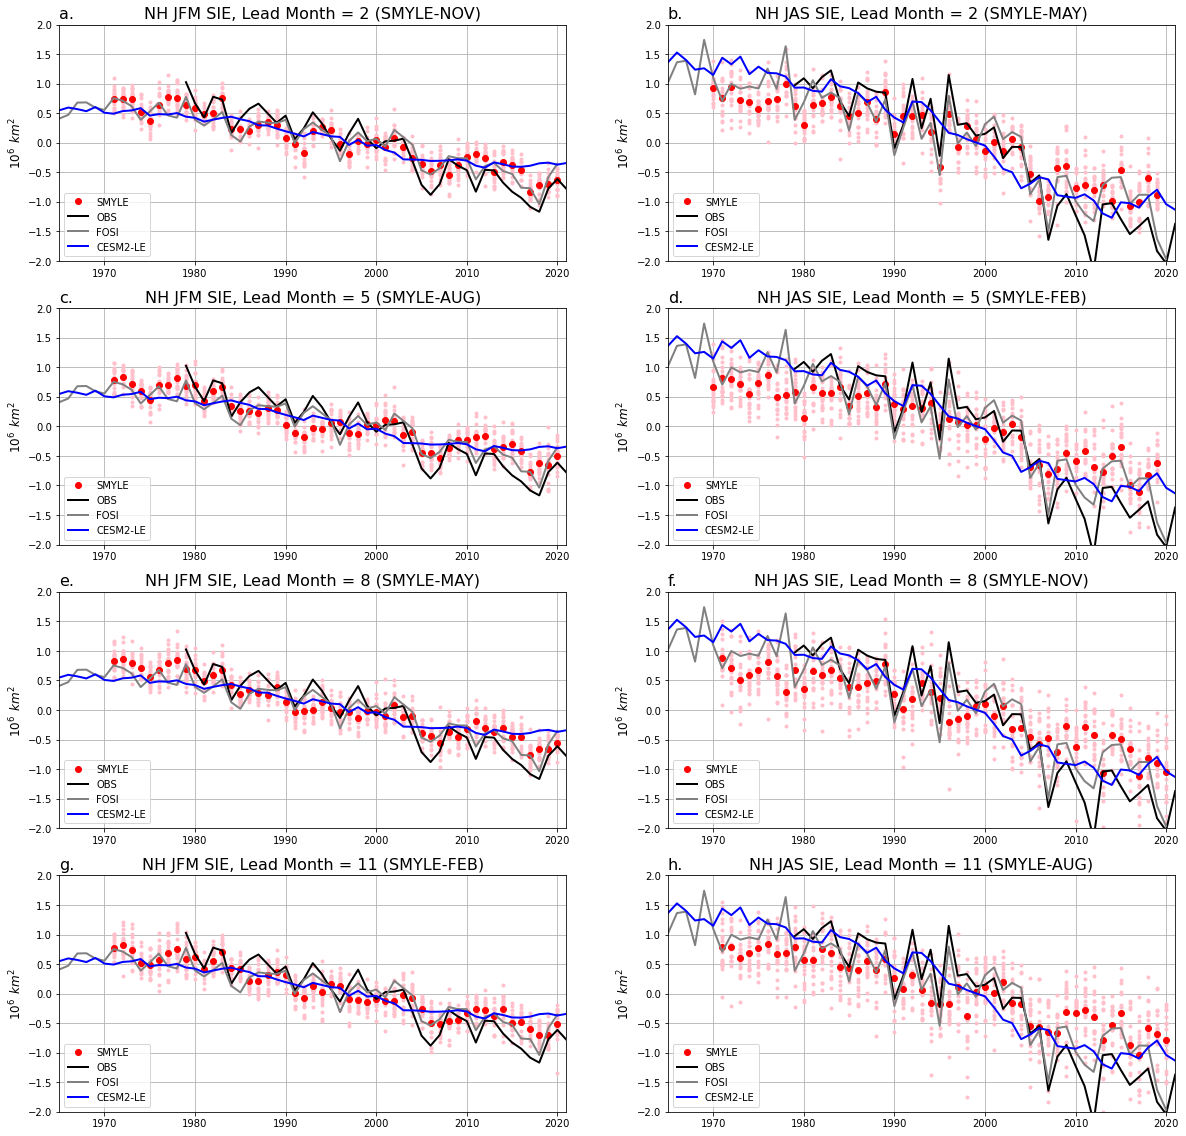

In [67]:
leads = [4,7,10,13]
nlead = np.size(leads)
fig = plt.figure(figsize=(20, nlead*5))
nrow = nlead
ncol = 2
seasons = {2:'JFM',5:'AMJ',8:'JAS',11:'OND'}

xtickyears = [1960,1965,1975,1985,1995,2005,2015]
xticks = [cftime.num2date(0, 'days since '+str(i)+'-01-01 00:00:00', calendar='noleap') for i in xtickyears]
xmin = 1965
xmax = 2021
ymin = -2
ymax = 2
printskill = True

lead = leads[0]
ax = fig.add_subplot(nrow,ncol,1)
smylemon = smyle11_time.sel(L=lead).dt.month.data[0]
smyleyear = smyle11_time.sel(L=lead).dt.year
smyledata = smyle11_sie_dd.sel(L=lead)
ax.plot(smyleyear,smyledata,'.',color='pink')
ax.plot(smyleyear,smyledata.mean('M'),'o',color='r',label='SMYLE')
ax.plot(obsjfm.time, obsjfm,linewidth=2,color='k',label='OBS')
ax.plot(fosijfm.time, fosijfm,linewidth=2,color='grey',label='FOSI')
ax.plot(cesm2jfm.time, cesm2jfm,linewidth=2,color='blue',label='CESM2-LE')
ax.grid()
ax.set_title('NH {} SIE, Lead Month = {} (SMYLE-NOV)'.format(seasons[smylemon],lead-2), fontdict={'size':16})
ax.set_title('a.', loc='left',fontdict={'size':16})
ax.set_ylabel('$10^6 \:\: km^{2}$',fontsize=12)
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)
ax.legend(loc='lower left')
if (printskill):
    ax.text(2000,1.6,'Corr:',horizontalalignment='right',fontsize=10)
    ax.text(2002,1.6,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_wfosi_dt.sel(L=lead).corr.data,smyle11_fosiskill_dt.sel(L=lead).corr.data),color='red',fontsize=10)
    ax.text(2012,1.6,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_wcesm_dt.sel(L=lead).corr2.data,smyle11_fosiskill_dt.sel(L=lead).corr2.data),color='blue',fontsize=10)
    ax.text(2000,1.2,'nRMSE:',horizontalalignment='right',fontsize=10)
    ax.text(2002,1.2,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_wfosi_dt.sel(L=lead).rmse.data,smyle11_fosiskill_dt.sel(L=lead).rmse.data),color='red',fontsize=10)
    ax.text(2012,1.2,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_wcesm_dt.sel(L=lead).rmse2.data,smyle11_fosiskill_dt.sel(L=lead).rmse2.data),color='blue',fontsize=10)

ax = fig.add_subplot(nrow,ncol,2)
smylemon = smyle05_time.sel(L=lead).dt.month.data[0]
smyleyear = smyle05_time.sel(L=lead).dt.year
smyledata = smyle05_sie_dd.sel(L=lead)
ax.plot(smyleyear,smyledata,'.',color='pink')
ax.plot(smyleyear,smyledata.mean('M'),'o',color='r',label='SMYLE')
ax.plot(obsjas.time, obsjas,linewidth=2,color='k',label='OBS')
ax.plot(fosijas.time, fosijas,linewidth=2,color='grey',label='FOSI')
ax.plot(cesm2jas.time, cesm2jas,linewidth=2,color='blue',label='CESM2-LE')
ax.grid()
ax.set_title('NH {} SIE, Lead Month = {} (SMYLE-MAY)'.format(seasons[smylemon],lead-2), fontdict={'size':16})
ax.set_title('b.', loc='left',fontdict={'size':16})
ax.set_ylabel('$10^6 \:\: km^{2}$',fontsize=12)
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)
ax.legend(loc='lower left')
if (printskill):
    ax.text(2000,1.6,'Corr:',horizontalalignment='right',fontsize=10)
    ax.text(2002,1.6,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_wfosi_dt.sel(L=lead).corr.data,smyle05_fosiskill_dt.sel(L=lead).corr.data),color='red',fontsize=10)
    ax.text(2012,1.6,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_wcesm_dt.sel(L=lead).corr2.data,smyle05_fosiskill_dt.sel(L=lead).corr2.data),color='blue',fontsize=10)
    ax.text(2000,1.2,'nRMSE:',horizontalalignment='right',fontsize=10)
    ax.text(2002,1.2,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_wfosi_dt.sel(L=lead).rmse.data,smyle05_fosiskill_dt.sel(L=lead).rmse.data),color='red',fontsize=10)
    ax.text(2012,1.2,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_wcesm_dt.sel(L=lead).rmse2.data,smyle05_fosiskill_dt.sel(L=lead).rmse2.data),color='blue',fontsize=10)

lead = leads[1]
ax = fig.add_subplot(nrow,ncol,3)
smylemon = smyle08_time.sel(L=lead).dt.month.data[0]
smyleyear = smyle08_time.sel(L=lead).dt.year
smyledata = smyle08_sie_dd.sel(L=lead)
ax.plot(smyleyear,smyledata,'.',color='pink')
ax.plot(smyleyear,smyledata.mean('M'),'o',color='r',label='SMYLE')
ax.plot(obsjfm.time, obsjfm,linewidth=2,color='k',label='OBS')
ax.plot(fosijfm.time, fosijfm,linewidth=2,color='grey',label='FOSI')
ax.plot(cesm2jfm.time, cesm2jfm,linewidth=2,color='blue',label='CESM2-LE')
ax.grid()
ax.set_title('NH {} SIE, Lead Month = {} (SMYLE-AUG)'.format(seasons[smylemon],lead-2), fontdict={'size':16})
ax.set_title('c.', loc='left',fontdict={'size':16})
ax.set_ylabel('$10^6 \:\: km^{2}$',fontsize=12)
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)
ax.legend(loc='lower left')
if (printskill):
    ax.text(2000,1.6,'Corr:',horizontalalignment='right',fontsize=10)
    ax.text(2002,1.6,'{0:3.2f} ({1:3.2f})'.format(smyle08_skill_wfosi_dt.sel(L=lead).corr.data,smyle08_fosiskill_dt.sel(L=lead).corr.data),color='red',fontsize=10)
    ax.text(2012,1.6,'{0:3.2f} ({1:3.2f})'.format(smyle08_skill_wcesm_dt.sel(L=lead).corr2.data,smyle08_fosiskill_dt.sel(L=lead).corr2.data),color='blue',fontsize=10)
    ax.text(2000,1.2,'nRMSE:',horizontalalignment='right',fontsize=10)
    ax.text(2002,1.2,'{0:3.2f} ({1:3.2f})'.format(smyle08_skill_wfosi_dt.sel(L=lead).rmse.data,smyle08_fosiskill_dt.sel(L=lead).rmse.data),color='red',fontsize=10)
    ax.text(2012,1.2,'{0:3.2f} ({1:3.2f})'.format(smyle08_skill_wcesm_dt.sel(L=lead).rmse2.data,smyle08_fosiskill_dt.sel(L=lead).rmse2.data),color='blue',fontsize=10)

ax = fig.add_subplot(nrow,ncol,4)
smylemon = smyle02_time.sel(L=lead).dt.month.data[0]
smyleyear = smyle02_time.sel(L=lead).dt.year
smyledata = smyle02_sie_dd.sel(L=lead)
ax.plot(smyleyear,smyledata,'.',color='pink')
ax.plot(smyleyear,smyledata.mean('M'),'o',color='r',label='SMYLE')
ax.plot(obsjas.time, obsjas,linewidth=2,color='k',label='OBS')
ax.plot(fosijas.time, fosijas,linewidth=2,color='grey',label='FOSI')
ax.plot(cesm2jas.time, cesm2jas,linewidth=2,color='blue',label='CESM2-LE')
ax.grid()
ax.set_title('NH {} SIE, Lead Month = {} (SMYLE-FEB)'.format(seasons[smylemon],lead-2), fontdict={'size':16})
ax.set_title('d.', loc='left',fontdict={'size':16})
ax.set_ylabel('$10^6 \:\: km^{2}$',fontsize=12)
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)
ax.legend(loc='lower left')
if (printskill):
    ax.text(2000,1.6,'Corr:',horizontalalignment='right',fontsize=10)
    ax.text(2002,1.6,'{0:3.2f} ({1:3.2f})'.format(smyle02_skill_wfosi_dt.sel(L=lead).corr.data,smyle02_fosiskill_dt.sel(L=lead).corr.data),color='red',fontsize=10)
    ax.text(2012,1.6,'{0:3.2f} ({1:3.2f})'.format(smyle02_skill_wcesm_dt.sel(L=lead).corr2.data,smyle02_fosiskill_dt.sel(L=lead).corr2.data),color='blue',fontsize=10)
    ax.text(2000,1.2,'nRMSE:',horizontalalignment='right',fontsize=10)
    ax.text(2002,1.2,'{0:3.2f} ({1:3.2f})'.format(smyle02_skill_wfosi_dt.sel(L=lead).rmse.data,smyle02_fosiskill_dt.sel(L=lead).rmse.data),color='red',fontsize=10)
    ax.text(2012,1.2,'{0:3.2f} ({1:3.2f})'.format(smyle02_skill_wcesm_dt.sel(L=lead).rmse2.data,smyle02_fosiskill_dt.sel(L=lead).rmse2.data),color='blue',fontsize=10)

lead = leads[2]
ax = fig.add_subplot(nrow,ncol,5)
smylemon = smyle05_time.sel(L=lead).dt.month.data[0]
smyleyear = smyle05_time.sel(L=lead).dt.year
smyledata = smyle05_sie_dd.sel(L=lead)
ax.plot(smyleyear,smyledata,'.',color='pink')
ax.plot(smyleyear,smyledata.mean('M'),'o',color='r',label='SMYLE')
ax.plot(obsjfm.time, obsjfm,linewidth=2,color='k',label='OBS')
ax.plot(fosijfm.time, fosijfm,linewidth=2,color='grey',label='FOSI')
ax.plot(cesm2jfm.time, cesm2jfm,linewidth=2,color='blue',label='CESM2-LE')
ax.grid()
ax.set_title('NH {} SIE, Lead Month = {} (SMYLE-MAY)'.format(seasons[smylemon],lead-2), fontdict={'size':16})
ax.set_title('e.', loc='left',fontdict={'size':16})
ax.set_ylabel('$10^6 \:\: km^{2}$',fontsize=12)
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)
ax.legend(loc='lower left')
if (printskill):
    ax.text(2000,1.6,'Corr:',horizontalalignment='right',fontsize=10)
    ax.text(2002,1.6,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_wfosi_dt.sel(L=lead).corr.data,smyle05_fosiskill_dt.sel(L=lead).corr.data),color='red',fontsize=10)
    ax.text(2012,1.6,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_wcesm_dt.sel(L=lead).corr2.data,smyle05_fosiskill_dt.sel(L=lead).corr2.data),color='blue',fontsize=10)
    ax.text(2000,1.2,'nRMSE:',horizontalalignment='right',fontsize=10)
    ax.text(2002,1.2,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_wfosi_dt.sel(L=lead).rmse.data,smyle05_fosiskill_dt.sel(L=lead).rmse.data),color='red',fontsize=10)
    ax.text(2012,1.2,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_wcesm_dt.sel(L=lead).rmse2.data,smyle05_fosiskill_dt.sel(L=lead).rmse2.data),color='blue',fontsize=10)

ax = fig.add_subplot(nrow,ncol,6)
smylemon = smyle11_time.sel(L=lead).dt.month.data[0]
smyleyear = smyle11_time.sel(L=lead).dt.year
smyledata = smyle11_sie_dd.sel(L=lead)
ax.plot(smyleyear,smyledata,'.',color='pink')
ax.plot(smyleyear,smyledata.mean('M'),'o',color='r',label='SMYLE')
ax.plot(obsjas.time, obsjas,linewidth=2,color='k',label='OBS')
ax.plot(fosijas.time, fosijas,linewidth=2,color='grey',label='FOSI')
ax.plot(cesm2jas.time, cesm2jas,linewidth=2,color='blue',label='CESM2-LE')
ax.grid()
ax.set_title('NH {} SIE, Lead Month = {} (SMYLE-NOV)'.format(seasons[smylemon],lead-2), fontdict={'size':16})
ax.set_title('f.', loc='left',fontdict={'size':16})
ax.set_ylabel('$10^6 \:\: km^{2}$',fontsize=12)
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)
ax.legend(loc='lower left')
if (printskill):
    ax.text(2000,1.6,'Corr:',horizontalalignment='right',fontsize=10)
    ax.text(2002,1.6,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_wfosi_dt.sel(L=lead).corr.data,smyle11_fosiskill_dt.sel(L=lead).corr.data),color='red',fontsize=10)
    ax.text(2012,1.6,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_wcesm_dt.sel(L=lead).corr2.data,smyle11_fosiskill_dt.sel(L=lead).corr2.data),color='blue',fontsize=10)
    ax.text(2000,1.2,'nRMSE:',horizontalalignment='right',fontsize=10)
    ax.text(2002,1.2,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_wfosi_dt.sel(L=lead).rmse.data,smyle11_fosiskill_dt.sel(L=lead).rmse.data),color='red',fontsize=10)
    ax.text(2012,1.2,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_wcesm_dt.sel(L=lead).rmse2.data,smyle11_fosiskill_dt.sel(L=lead).rmse2.data),color='blue',fontsize=10)

lead = leads[3]
ax = fig.add_subplot(nrow,ncol,7)
smylemon = smyle02_time.sel(L=lead).dt.month.data[0]
smyleyear = smyle02_time.sel(L=lead).dt.year
smyledata = smyle02_sie_dd.sel(L=lead)
ax.plot(smyleyear,smyledata,'.',color='pink')
ax.plot(smyleyear,smyledata.mean('M'),'o',color='r',label='SMYLE')
ax.plot(obsjfm.time, obsjfm,linewidth=2,color='k',label='OBS')
ax.plot(fosijfm.time, fosijfm,linewidth=2,color='grey',label='FOSI')
ax.plot(cesm2jfm.time, cesm2jfm,linewidth=2,color='blue',label='CESM2-LE')
ax.grid()
ax.set_title('NH {} SIE, Lead Month = {} (SMYLE-FEB)'.format(seasons[smylemon],lead-2), fontdict={'size':16})
ax.set_title('g.', loc='left',fontdict={'size':16})
ax.set_ylabel('$10^6 \:\: km^{2}$',fontsize=12)
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)
ax.legend(loc='lower left')
if (printskill):
    ax.text(2000,1.6,'Corr:',horizontalalignment='right',fontsize=10)
    ax.text(2002,1.6,'{0:3.2f} ({1:3.2f})'.format(smyle02_skill_wfosi_dt.sel(L=lead).corr.data,smyle02_fosiskill_dt.sel(L=lead).corr.data),color='red',fontsize=10)
    ax.text(2012,1.6,'{0:3.2f} ({1:3.2f})'.format(smyle02_skill_wcesm_dt.sel(L=lead).corr2.data,smyle02_fosiskill_dt.sel(L=lead).corr2.data),color='blue',fontsize=10)
    ax.text(2000,1.2,'nRMSE:',horizontalalignment='right',fontsize=10)
    ax.text(2002,1.2,'{0:3.2f} ({1:3.2f})'.format(smyle02_skill_wfosi_dt.sel(L=lead).rmse.data,smyle02_fosiskill_dt.sel(L=lead).rmse.data),color='red',fontsize=10)
    ax.text(2012,1.2,'{0:3.2f} ({1:3.2f})'.format(smyle02_skill_wcesm_dt.sel(L=lead).rmse2.data,smyle02_fosiskill_dt.sel(L=lead).rmse2.data),color='blue',fontsize=10)

ax = fig.add_subplot(nrow,ncol,8)
smylemon = smyle08_time.sel(L=lead).dt.month.data[0]
smyleyear = smyle08_time.sel(L=lead).dt.year
smyledata = smyle08_sie_dd.sel(L=lead)
ax.plot(smyleyear,smyledata,'.',color='pink')
ax.plot(smyleyear,smyledata.mean('M'),'o',color='r',label='SMYLE')
ax.plot(obsjas.time, obsjas,linewidth=2,color='k',label='OBS')
ax.plot(fosijas.time, fosijas,linewidth=2,color='grey',label='FOSI')
ax.plot(cesm2jas.time, cesm2jas,linewidth=2,color='blue',label='CESM2-LE')
ax.grid()
ax.set_title('NH {} SIE, Lead Month = {} (SMYLE-AUG)'.format(seasons[smylemon],lead-2), fontdict={'size':16})
ax.set_title('h.', loc='left',fontdict={'size':16})
ax.set_ylabel('$10^6 \:\: km^{2}$',fontsize=12)
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)
ax.legend(loc='lower left')
if (printskill):
    ax.text(2000,1.6,'Corr:',horizontalalignment='right',fontsize=10)
    ax.text(2002,1.6,'{0:3.2f} ({1:3.2f})'.format(smyle08_skill_wfosi_dt.sel(L=lead).corr.data,smyle08_fosiskill_dt.sel(L=lead).corr.data),color='red',fontsize=10)
    ax.text(2012,1.6,'{0:3.2f} ({1:3.2f})'.format(smyle08_skill_wcesm_dt.sel(L=lead).corr2.data,smyle08_fosiskill_dt.sel(L=lead).corr2.data),color='blue',fontsize=10)
    ax.text(2000,1.2,'nRMSE:',horizontalalignment='right',fontsize=10)
    ax.text(2002,1.2,'{0:3.2f} ({1:3.2f})'.format(smyle08_skill_wfosi_dt.sel(L=lead).rmse.data,smyle08_fosiskill_dt.sel(L=lead).rmse.data),color='red',fontsize=10)
    ax.text(2012,1.2,'{0:3.2f} ({1:3.2f})'.format(smyle08_skill_wcesm_dt.sel(L=lead).rmse2.data,smyle08_fosiskill_dt.sel(L=lead).rmse2.data),color='blue',fontsize=10)

plt.savefig('f12.png')